In [1]:
import os
import pandas as pd
from mplsoccer.pitch import Pitch
import numpy as np
from scipy.stats import binned_statistic_2d
np.random.seed(777)

Load the data

In [2]:
df = pd.read_parquet(os.path.join('..', '..', 'data', 'shots.parquet'))

Pitch for binning the data

In [3]:
pitch = Pitch(pitch_type='statsperform', figsize=(16, 12), #pad_left=-10, pad_right=-10, pad_bottom=-10,
              orientation='vertical', view='half', line_zorder=2)

Bin the data into roughly 2 metre squaresm

In [4]:
pitch_range = [[pitch.left, pitch.right], [pitch.bottom, pitch.top]]
result = binned_statistic_2d(df.x, df.y, values=df.x, statistic='count', bins=(53, 34), expand_binnumbers=True,
                             range=pitch_range)

Identify outliers

In [5]:
result_percent = binned_statistic_2d(df.x, df.y, values=df.goal, statistic='mean', bins=(53, 34),
                                     expand_binnumbers=True,
                                     range=pitch_range)
xdim_outlier, ydim_outlier = ((np.nan_to_num(result_percent.statistic) >= 0.08) & (result.statistic < 20)).nonzero()
df_bins = pd.DataFrame({'bin_x': xdim_outlier + 1, 'bin_y': ydim_outlier + 1})
df['bin_x'] = result_percent.binnumber[0, :]
df['bin_y'] = result_percent.binnumber[1, :]
df_bins['outlier'] = True
df = df.merge(df_bins, on=['bin_x', 'bin_y'], how='left')

Generate some random data coordinates

In [6]:
x = np.arange(0, 105, 0.1)
y = np.arange(0, 68, 0.1)
x_random = np.random.choice(x, size=71400, replace=True)
y_random = np.random.choice(y, size=71400, replace=True)

Bin the random coordinates

In [7]:
result_random = binned_statistic_2d(x_random, y_random, values=x_random, statistic='count', bins=(53, 34),
                                    expand_binnumbers=True, range=pitch_range)
df_fake = pd.DataFrame({'x': x_random, 'y': y_random})
df_fake['bin_x'] = result_random.binnumber[0, :]
df_fake['bin_y'] = result_random.binnumber[1, :]

Keep only data in the fake data coordinates where there are fewer than 100 shots in the square

In [8]:
x_dim, y_dim = (result.statistic < 100).nonzero()
df_bins_to_add = pd.DataFrame({'bin_x': x_dim + 1, 'bin_y': y_dim + 1})
df_fake = df_fake.merge(df_bins_to_add, how='inner', on=['bin_x', 'bin_y'])

Remove the area infront of the goals

In [9]:
mask_infront_goal = (df_fake.bin_x > 52) & (df_fake.bin_y > 13) & (df_fake.bin_y < 22)
df_fake = df_fake[~mask_infront_goal].copy()

Remove area close to defensive goal (first 18 squares)

In [10]:
mask_defence = (df_fake.bin_x < 18)
df_fake = df_fake[~mask_defence].copy()

Keep area inside the penalty box

In [11]:
mask_pen_area = (df_fake.bin_x > 45) &  (df_fake.bin_x < 53) & (df_fake.bin_y > 7) & (df_fake.bin_y < 28)
mask_tight = (df_fake.bin_x == 53) & (df_fake.bin_y > 7) & (df_fake.bin_y < 28)
df_fake['tight'] = mask_tight
df_fake['pen_area'] = mask_pen_area

Sample 1000 of the fake shots

In [12]:
df_fake = df_fake[mask_tight | mask_pen_area].copy()
df_fake = df_fake.sample(1000)

Calculate the average goal probability from these areas (around 4%)

In [13]:
grids = df_fake[['bin_x', 'bin_y', 'pen_area']].drop_duplicates()
df = df.merge(grids, how='left')
mean_other_shots = df[df.pen_area == True].goal.mean()
print(mean_other_shots)

0.0406885758998435


If tight angle = No Goal

In [14]:
df_fake.loc[df_fake['tight'], 'goal'] = False

Otherwise set to the percentage above

In [15]:
goal1 = df_fake[df_fake.pen_area].groupby(['bin_x', 'bin_y']).apply(lambda x: x.sample(frac=mean_other_shots))
goal_idx1 = goal1.drop(['bin_x', 'bin_y'], axis=1).reset_index().level_2
df_fake.loc[df_fake.index.isin(goal_idx1), 'goal'] = True
df_fake.loc[df_fake.goal.isnull(), 'goal'] = False
df_fake['goal'] = df_fake['goal'].astype(np.bool)
df_fake.reset_index(drop=True, inplace=True)

Show areas with fake shots

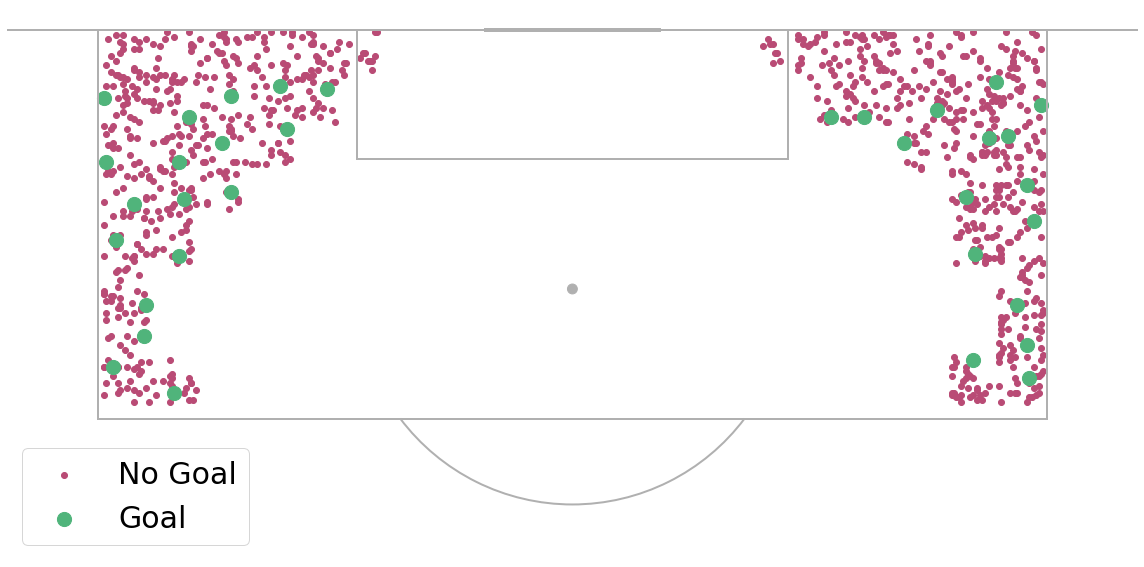

In [16]:
pitch = Pitch(pitch_type='statsperform', figsize=(16, 12), pad_left=-10, pad_right=-10, pad_bottom=-30, pad_top=1,
              orientation='vertical', view='half', line_zorder=2)
fig, ax = pitch.draw()
pitch.scatter(df_fake[~df_fake['goal']].x, df_fake[~df_fake['goal']].y, color='#b94b75', label='No Goal', ax=ax)
pitch.scatter(df_fake[df_fake['goal']].x, df_fake[df_fake['goal']].y, color='#50b47b', s=200, label='Goal', ax=ax)
ax.legend(fontsize=30)
fig.savefig(os.path.join('..', 'figures', 'fake_data_added.png'), bbox_inches = 'tight', pad_inches = 0.2)

Fill in the other features from a randomly sampled row in the data from the same area (penalty area/ other)

In [17]:
cols_in_lgbm_model = ['shot_type_name', 'counter_attack', 'fast_break',
                       'strong_foot', 'body_part_name', 'assist_type', 'pass_end_y',
                       'pass_end_x', 'pass_switch', 'pass_cross', 'pass_cut_back',
                       'pass_height_name', 'pass_technique_name', 'carry_length',
                       'shot_one_on_one', 'shot_open_goal', 'under_pressure', 'area_shot', 'smart_pass',
                       'area_goal', 'n_angle', 'goalkeeper_x', 'goalkeeper_y']

In [18]:
df_pen = df.loc[df.pen_area == True, cols_in_lgbm_model].copy()
df_pen = df_pen.sample(n=1000, replace=True).reset_index(drop=True)
df_fake = df_fake.merge(df_pen, left_index=True, right_index=True)

In [19]:
df_fake.drop(['bin_x', 'bin_y', 'tight', 'pen_area'], axis=1, inplace=True)

Check before adding fake data. Less smooth

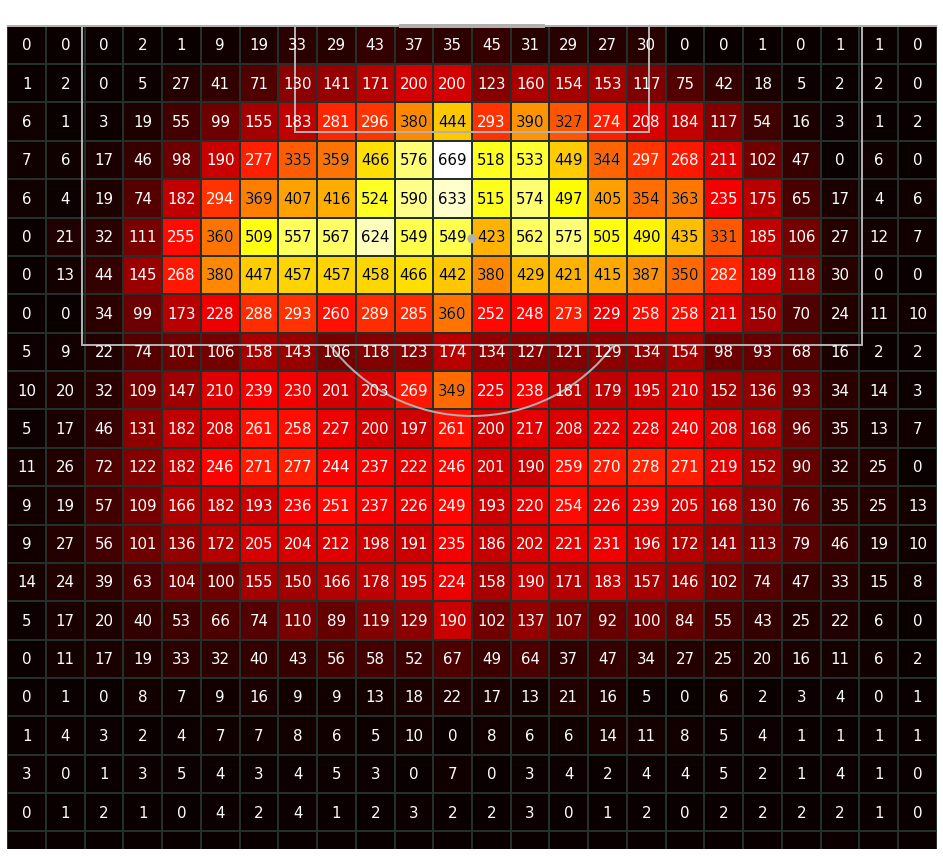

In [20]:
pitch = Pitch(pitch_type='statsperform', figsize=(16, 12), pad_left=-10, pad_right=-10, pad_bottom=-10, pad_top=1,
              orientation='vertical', view='half', line_zorder=2)
fig, ax = pitch.draw()
bs = pitch.bin_statistic(df.x, df.y, statistic='count', bins=(53, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
bs['statistic'] = np.nan_to_num(bs['statistic'])
bs['statistic'] = (bs['statistic']).astype(np.int32)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
mask = bs['statistic'] > 300
bs['statistic'] = bs['statistic'].astype(str)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='center', zorder=4)
fig.savefig(os.path.join('..', 'figures', 'number_of_shots_by_location.png'), bbox_inches = 'tight', pad_inches = 0.2)

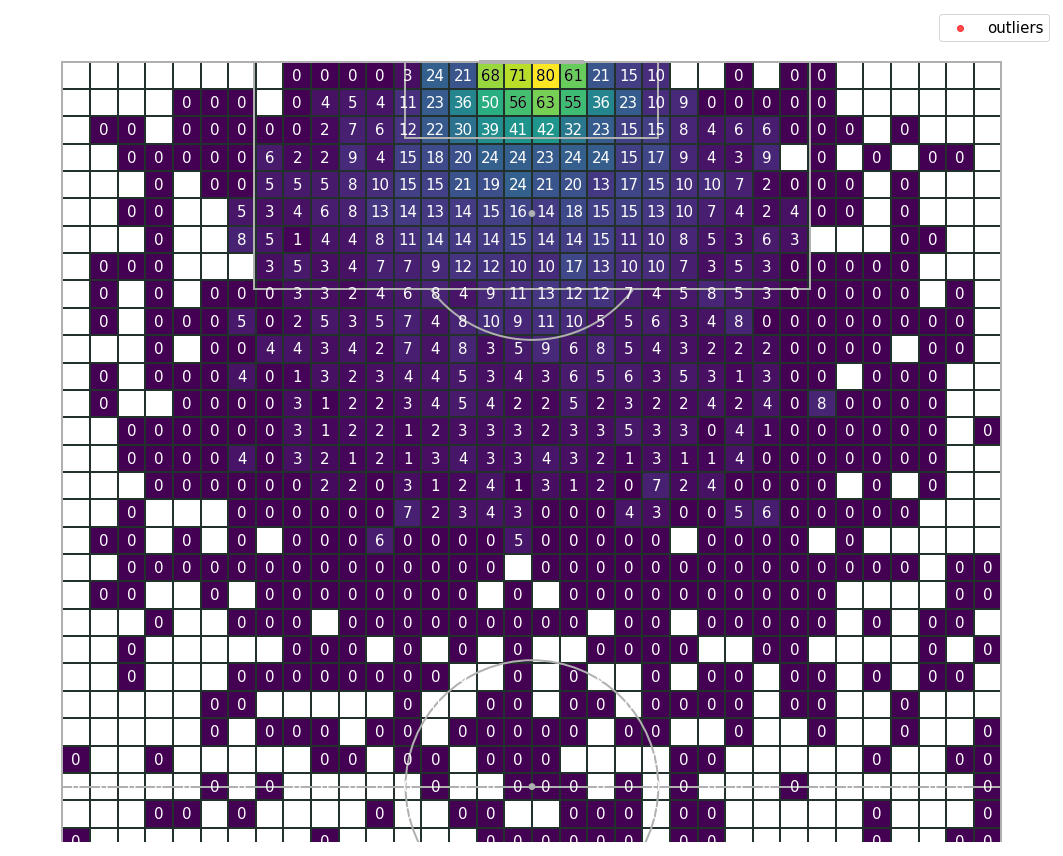

In [21]:
pitch = Pitch(pitch_type='statsperform', figsize=(16, 12), #pad_left=-10, pad_right=-10, pad_bottom=-10,
              orientation='vertical', view='half', line_zorder=2)
fig, ax = pitch.draw()
bs = pitch.bin_statistic(df.x, df.y, values=df.goal,  statistic='mean', bins=(53, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='viridis', edgecolors='#22312b')
bs['statistic'] = np.nan_to_num(bs['statistic'])
bs['statistic'] = np.round(bs['statistic'] * 100., 0).astype(np.int32)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
mask = bs['statistic'] > 50
bs['statistic'] = bs['statistic'].astype(str)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='center', zorder=4)
pitch.scatter(df[df['outlier']==True].x, df[df['outlier']==True].y, ax=ax, color='red', label='outliers', alpha=0.7)
ax.legend(fontsize=15)
fig.savefig(os.path.join('..', 'figures', 'outliers.png'), bbox_inches = 'tight', pad_inches = 0.2)

Check after adding fake data - scoring percentages

In [22]:
df_with_fake = pd.concat([df_fake[['x', 'y', 'goal']], df.loc[~(df.outlier == True), ['x', 'y', 'goal']]])

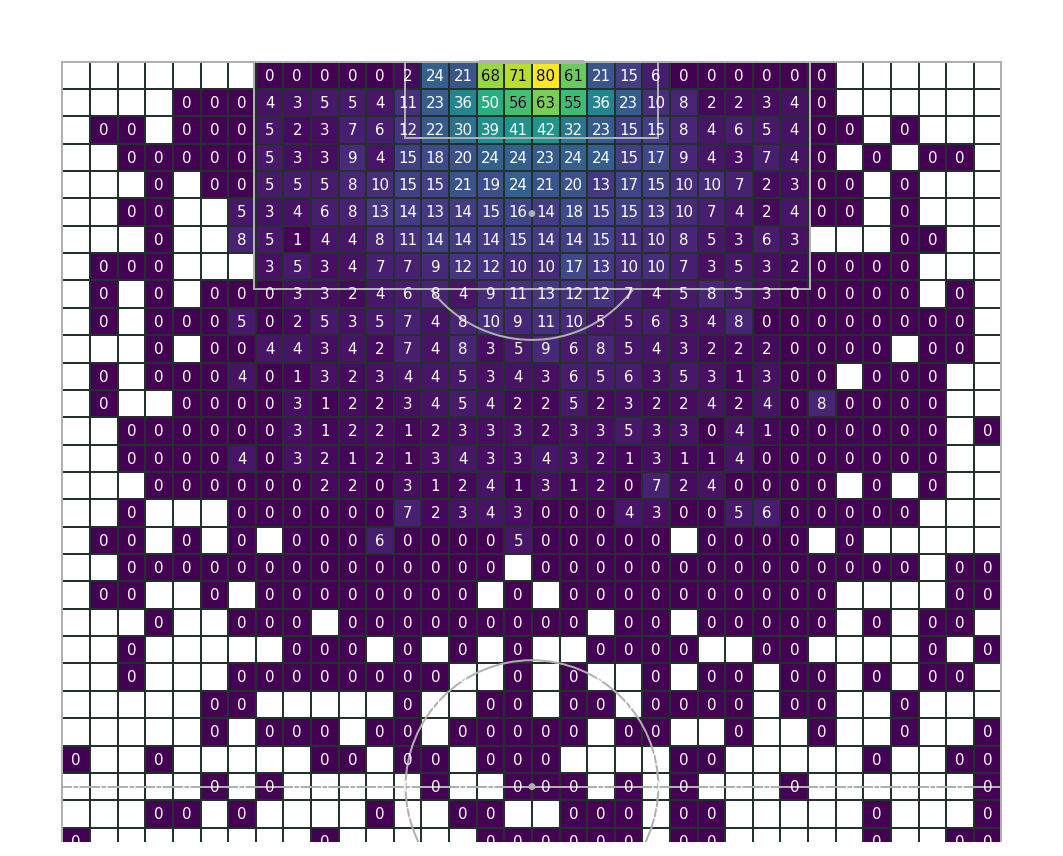

In [23]:
pitch = Pitch(pitch_type='statsperform', figsize=(16, 12), orientation='vertical', view='half', line_zorder=2)
fig, ax = pitch.draw()
bs = pitch.bin_statistic(df_with_fake.x, df_with_fake.y, values=df_with_fake.goal,  statistic='mean', bins=(53, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='viridis', edgecolors='#22312b')
bs['statistic'] = np.nan_to_num(bs['statistic'])
bs['statistic'] = np.round(bs['statistic'] * 100., 0).astype(np.int32)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
mask = bs['statistic'] > 50
bs['statistic'] = bs['statistic'].astype(str)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='center', zorder=4)
fig.savefig(os.path.join('..', 'figures', 'raw_goal_probabilities_with_fake_and_removing_outliers.png'),
            bbox_inches = 'tight', pad_inches = 0.2)

# Save fake data

In [24]:
df_fake.to_parquet(os.path.join('..', '..', 'data', 'fake_shots.parquet'))

In [25]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   x                    1000 non-null   float64
 1   y                    1000 non-null   float64
 2   goal                 1000 non-null   bool   
 3   shot_type_name       1000 non-null   object 
 4   counter_attack       1000 non-null   bool   
 5   fast_break           1000 non-null   bool   
 6   strong_foot          1000 non-null   bool   
 7   body_part_name       1000 non-null   object 
 8   assist_type          1000 non-null   object 
 9   pass_end_y           243 non-null    float64
 10  pass_end_x           243 non-null    float64
 11  pass_switch          712 non-null    object 
 12  pass_cross           712 non-null    object 
 13  pass_cut_back        712 non-null    object 
 14  pass_height_name     712 non-null    object 
 15  pass_technique_name  712 non-null    ob

# Save shot dataset. Remove outliers and extra columns

In [26]:
print('Outliers removed;', df.outlier.notnull().sum())
df = df[df.outlier.isnull()].copy()
df.drop(['bin_x', 'bin_y', 'outlier', 'pen_area'], axis=1, inplace=True)
df.to_parquet(os.path.join('..', '..', 'data', 'shots.parquet'))

Outliers removed; 227
